In [1]:
import requests
from pandas import json_normalize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statistics

# additional imports for implied vols
import json
import time
from datetime import date, datetime, timedelta
import warnings
import random

from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd
from pandas import DataFrame

import re

In [2]:
# FTX API Info
FTX_ENDPOINT = "https://ftx.com/api/"

In [3]:
# Functions
def get_candlesticks(market: str, days_to_maturity: int):
    """
    Grabs historical daily candlesticks from FTX for a given market.
    
    Args:
        market: Currency pair (BTC/USD)
        days_to_maturity: Days to option maturity
    """
    params = {
    'resolution': 86400,  # 86400 seconds in a daily for daily candlesticks
    'limit': days_to_maturity*3
    }
    
    path = f"markets/{market}/candles"
    response = requests.get(FTX_ENDPOINT+path, params)
    data = response.json()
    df = json_normalize(data['result'])
    assert len(df) == days_to_maturity*3
    return df

def calc_daily_returns(candlesticks: pd.DataFrame):
    """Calculates daily price change percentages given a DataFrame of OHLC data.
    
    Changes are reflected in decimals. i.e. (4% = 0.04)
    """
    daily_returns = []
    for idx, row in candlesticks.iterrows():
        daily_returns.append((row['close'] - row['open']) / row['open']) # Price difference as a percentage of open price
    return np.array(daily_returns)

def calc_close_to_close_vol(candlesticks: pd.DataFrame):
    """Calculates daily price change percentages given a DataFrame of OHLC data.
    
    Changes are reflected in decimals. i.e. (4% = 0.04)
    
    close to close volatility
    """
    daily_returns = []
    for idx, row in candlesticks.iterrows():
        daily_returns.append((row['close'] - row['open']) / row['open']) # Price difference as a percentage of open price
    
    daily_returns = np.array(daily_returns)
    
    return statistics.stdev(daily_returns)

def calc_parkinson_vol(candlesticks: pd.DataFrame):
    """Calculates daily parkinson vol
    """
    parkinson_vol = []
    for idx, row in candlesticks.iterrows():
        parkinson_vol.append((math.sqrt(math.log(row['high'] / row['low'])**2) / (4*math.log(2))))
    print(np.array(parkinson_vol))
    return np.array(parkinson_vol)

# calculates the ewma predicted close to close volatility
def ewma_future_close_to_close_vol(daily_returns: np.array, alpha: float):
    data = daily_returns
    
    weights = []
    for i in range(data.shape[0]):
        weights.append((1-alpha)*alpha**i)
    weights = weights[::-1]
    
    sum_of_weights = sum(weights)
    weights = np.array(weights)
    
    # normalizes the weights to sum up to 1
    normalized_weights = weights * (1/sum_of_weights)
    
    post_ewma_data = 0
    
    for i in range(data.shape[0]):
        post_ewma_data += data[i]**2 * normalized_weights[i]
        
    ewma_close_to_close_vol = math.sqrt(post_ewma_data)
    
#     future_vol = sum(post_weight_data)
    return ewma_close_to_close_vol

# function needs to be fixed most likely
def ewma_future_parkinson_vol(data: np.array, alpha: float):
    alpha = alpha
    weights = []
    for i in range(data.shape[0]):
        weights.append((1-alpha)*alpha**i)
    weights = weights[::-1]
    
    sum_of_weights = sum(weights)
    weights = np.array(weights)
    
    normalized_weights = weights * (1/sum_of_weights)
    
    post_weight_data = []
    
    for i in range(data.shape[0]):
        post_weight_data.append(data[i]*normalized_weights[i])
    
    future_vol = sum(post_weight_data)
    return future_vol

def calc_annualized_volatility(vol: float):
    return vol*math.sqrt(365)


In [4]:
# testing

# Globals
FUTURE_DAYS = 30
HISTORICAL_DAYS_BACK = 3*FUTURE_DAYS
ASSET = "ETH"

# get historical data 
df = get_candlesticks(f"{ASSET}/USD", HISTORICAL_DAYS_BACK)

daily_returns = calc_daily_returns(df)
df['daily_returns'] = daily_returns

# close_to_close_vol = calc_close_to_close_vol(df)
# df['c2c_vol'] = close_to_close_vol

parkinson_vol = calc_parkinson_vol(df)
df['park_vol'] = parkinson_vol

# print(df)



[0.01987227 0.01452586 0.01795161 0.0360259  0.03580734 0.0160572
 0.01674061 0.01932703 0.01969314 0.02582036 0.01691024 0.01491323
 0.01033286 0.01679218 0.01059107 0.01598435 0.00965579 0.03110744
 0.01570572 0.02334935 0.00950943 0.0141508  0.01784501 0.03822124
 0.02049766 0.03374574 0.02941962 0.01945909 0.01502973 0.02616385
 0.0280878  0.01749059 0.02522156 0.05496534 0.01364442 0.02987948
 0.01502286 0.03275375 0.01981111 0.01672939 0.05238753 0.07121021
 0.0193227  0.03980541 0.01475525 0.01901368 0.03520329 0.03147557
 0.02501189 0.01668689 0.04401337 0.01885271 0.04228313 0.01445767
 0.02802695 0.02157953 0.0139895  0.02164851 0.01355495 0.01277404
 0.0236379  0.01245469 0.01064184 0.00895296 0.00852968 0.02584183
 0.02175796 0.01831284 0.01882912 0.00995212 0.01342471 0.0163187
 0.01725497 0.04362176 0.0265061  0.03965184 0.0288656  0.01773267
 0.03067841 0.02435256 0.02273185 0.01957107 0.01760811 0.01220529
 0.01316683 0.02412011 0.0184592  0.01497903 0.03334328 0.075154

In [5]:
close_to_close_future_vol = ewma_future_close_to_close_vol(daily_returns, 0.97)

print('close to close predicted daily vol: ' + str(close_to_close_future_vol))
print('close to close predicted annual vol: ' + str(math.sqrt(365)*close_to_close_future_vol))

parkinson_future_vol = ewma_future_parkinson_vol(parkinson_vol, 0.97)
print('parkinson predicted daily vol: ' + str(parkinson_future_vol))
print('parkinson predicted annual vol: ' + str(math.sqrt(365)*parkinson_future_vol))

close to close predicted daily vol: 0.05997219489663883
close to close predicted annual vol: 1.1457671747187375
parkinson predicted daily vol: 0.03148355838502551
parkinson predicted annual vol: 0.6014925383850644


In [6]:
# park_vol_ewm = df['park_vol'].ewm(alpha=0.97, adjust=True).mean()
# df['park_vol_ewm'] = park_vol_ewm

# df

Importing Implied Vol Curves Below

In [7]:
# below needed to pull genesis volatility curves
########GLOBAL VARIABLES#######################################
gvol_url = "https://app.pinkswantrading.com/graphql"
gvol_headers = {
    'x-oracle': 'U0AmGu36mbUtxvZcxjOV',
    'Content-Type': 'application/json',
    'accept': '*/*',
    'Accept-Language': 'en-US,en;q=0.9'
}

In [8]:
# functions with pulling vol curves
def get_historical_surface(date,symbol):
    queryname = "HifiVolSurface1DayOf1Min"

    query = """query HifiVolSurface1DayOf1Min($symbol:BTCOrETHEnumType, $date: String){
      HifiVolSurface1DayOf1Min(symbol:$symbol, date:$date){
        date
        timeLeft
        currency
        expiration
        underlyingPrice
        spot
        putD05
        putD15
        putD25
        putD35
        callD05
        callD15
        callD25
        callD35
        atmMarkIV
        atmMidIV
        atmBidIV
        atmAskIV
      }
    }"""
    variables = {
        "symbol": symbol,
        "date": date
    }
    response = requests.get(gvol_url, headers=gvol_headers, json={'query': query, 'variables': variables})
    out = response.json()['data'][queryname]
    data = json_normalize(out)
    data.to_csv("hist_skew_testtt.csv")
    return data


'''
Symbol: BTC (BTC/ETH) 
Interval: "1 minute" (5 minute, 15 minute, 30 minute , 1 hour, 4 hour, 12 hour, 1 day, 1 week) 
date: "2021-09-01"
'''

# pulls the real time genesis volatility curve surface
def pull_real_time_surface(asset: str):
    queryname = "UtilityRealtimeOptionbook"
    
    query = """query UtilityRealtimeOptionbook(
    		$exchange: ExchangeEnumType
    	) {
    		UtilityRealtimeOptionbook: genericUtilityRealtimeOptionbook(
    			exchange: $exchange
    			
    		) {
    			date
                instrumentName
                currency
                expiration
                strike
                putCall
                isAtm
                oi
                bestBidPrice
                usdBid
                bidIV
                markIv
                askIv
                indexPrice
                underlyingPrice
    		}
    	}"""
     
    variables = {
        "exchange": "deribit"
    }
    response = requests.get(gvol_url, headers=gvol_headers, json={'query': query, 'variables': variables})
    out = response.json()['data'][queryname]
    data = json_normalize(out)
    surface_asset = data[data['currency'] == asset]
    return surface_asset





In [9]:
# rewrote function find_closest to find the before and after closest points in a sorted list
def find_before_after(reference: float, choices: list):
    before = 0
    after = 0
    for i in range(len(choices)-1):
        
        # The truth value of an array with more than one element is ambiguous. Use a.any() or a.all() 
        if np.logical_and(choices[i] <= reference, reference <= choices[i+1]):
            before = choices[i]
            after = choices[i+1]
    if before == 0 or after == 0:
        if reference <= choices[0]:
            after = choices[0]
        
        # for days_until_maturity that exceeds the largest maturity
        elif choices[len(choices)-1] <= reference:
            before = choices[len(choices)-1]
    return before, after

print(find_before_after(2.8, [0.5, 1.5, 2.5]))
            
# not used currently
def find_closest(days_until_maturity,maturities):
    before = None
    after = None
    for mat in maturities:
        if mat < days_until_maturity:
            if before == None:
                before = mat
            else:
                dist_cur_best = abs(before-days_until_maturity)
                dist_new_best = abs(mat-days_until_maturity)
                if dist_new_best < dist_cur_best:
                    before = mat
        else:
            if after == None:
                after = mat
            else:
                dist_cur_best = abs(after - days_until_maturity)
                dist_new_best = abs(mat - days_until_maturity)
                if dist_new_best < dist_cur_best:
                    after = mat
    return before,after

# finds the weights for 
def distance_ratio(x1,x2):
    dw1 = 0
    dw2 = 0
    if x1 != None:
        if x2 == None:
            dw1 = 1
        else:
            dw1 = abs(1-x1/(x1+x2))

    if x2 != None:
        if x1 == None:
            dw2 = 1
        else:
            dw2 = abs(1-x2/(x1+x2))
    return dw1,dw2

print(distance_ratio(1,2))

(2.5, 0)
(0.6666666666666667, 0.33333333333333337)


In [10]:
# backtest - # of days to look back, alpha


def find_iv(coin: str, days_until_maturity: int, spot: float, strike: float):
    assets = ["ETH", coin]
    
    # industry standard for iv, can test different values
    ALPHA = 0.97
    
    # should be moderately based on input days_until_maturity
    rv_days = [7, 15, 30, 60]

    eth_rvs = []
    
    for day in rv_days:
        eth_rvs.append(ewma_future_close_to_close_vol(calc_daily_returns(
        get_candlesticks(f"{assets[0]}/USD", day)), ALPHA))
    
    coin_rvs = []
    
    for day in rv_days:
        coin_rvs.append(ewma_future_close_to_close_vol(calc_daily_returns(
        get_candlesticks(f"{assets[1]}/USD", day)), ALPHA))
        
    ## USE COMBO OF eth and coin rv to find mixed realized vol metric
    # look to improve 
    mixed_eth_rv = (sum(eth_rvs) / len(eth_rvs))
    mixed_coin_rv = (sum(coin_rvs) / len(coin_rvs))
    
    # this is the vol multiplier used to scale the eth vol curve to the coin vol curve
    vol_multiplier = mixed_coin_rv / mixed_eth_rv
    
    # how far is the coin out of the money
    
    # ML: need to check if spot is 0 to throw an error
    coin_otm_factor = strike / spot
    
    # how far is eth equivalently out of the money
    # ML: fixing to account for log relationship 7/19
    # K_SOL = K_ETH**2 if SOL is 2 times volatile of ETH
    # K_SOL = K_ETH**1.5 if SOL is 1.5 times volatile of ETH
    
    # eth_equiv_otm_factor = 1 + (coin_otm_factor-1) * mixed_eth_rv / mixed_coin_rv (wrong does not account for log returns)
    
    
    
    eth_equiv_otm_factor = (coin_otm_factor)**(1/vol_multiplier)
    
    # debugging
#     print('The strike is ' + str(strike))
#     print('The vol_multplier is ' + str(vol_multiplier))
#     print('The coin_otm_factor is ' + str(coin_otm_factor))
#     print('The eth_equiv_otm_factor is ' + str(eth_equiv_otm_factor))
    
    ## NEXT PULL IN THE ETH VOL SURFACE INSTRUMENTS
    surface_eth = pull_real_time_surface('ETH')
    
    # print(surface)
    now = datetime.now()
       
    surface_eth['time_to_exp'] = pd.to_datetime(surface_eth['expiration'], unit='ms') - now
    
    # ML: finds the days to expiry
    surface_eth['days'] = surface_eth['time_to_exp'].dt.total_seconds() / (24 * 60 * 60)
    
    # ML: finds how far everything is out of the money
    surface_eth['strike_vs_spot'] = surface_eth['strike'] / surface_eth['indexPrice']
    
    # print(surface_eth)
    
    # ML: returns sorted unique maturities
    maturities = surface_eth['days'].unique()
    
    # print(maturities)
    
    
    before,after = find_before_after(days_until_maturity, maturities)
    
    # finding the curves that correspond to the closest maturities (up-down axis)
    before_curve = surface_eth[surface_eth['days'] == before]
    after_curve = surface_eth[surface_eth['days']== after]
    
    # print(before_curve)
    
    ## next find two closest points on both curves
    ## next find closest maturities
    before_factors = before_curve['strike_vs_spot'].unique()
    after_factors = after_curve['strike_vs_spot'].unique()
    
    before_factors.sort()
    after_factors.sort()
    
    # print(before_factors)
    
    # ML: these are the four points that make up the box in which our predicted vol lies in
    before_factor_low, before_factor_high = find_before_after(eth_equiv_otm_factor, before_factors) # value error
    after_factor_low, after_factor_high = find_before_after(eth_equiv_otm_factor, after_factors)
#     print(before_factor_low)
#     print(before_curve[before_curve['strike_vs_spot'] == before_factor_low]['markIv'].iloc[0])
    
    # bottom left
    negdate_negstrike_vol = 0
    negdate_negstrike_dist = None
    
    # bottom right
    negdate_posstrike_vol = 0
    negdate_posstrike_dist = None
    
    # upper left
    posdate_negstrike_vol = 0
    posdate_negstrike_dist = None
    
    # upper right
    posdate_posstrike_vol = 0
    posdate_posstrike_dist = None
    
    before_dist = 0
    after_dist = 0
    if before != 0:
        before_dist = abs(days_until_maturity-before)
        if before_factor_low != 0:
            negdate_negstrike_vol = before_curve[before_curve['strike_vs_spot'] == before_factor_low]['markIv'].iloc[0]
            negdate_negstrike_dist = abs(before_factor_low-eth_equiv_otm_factor)
        if before_factor_high != 0:
            negdate_posstrike_vol = before_curve[before_curve['strike_vs_spot'] == before_factor_high]['markIv'].iloc[0]
            negdate_posstrike_dist = abs(before_factor_high-eth_equiv_otm_factor)

    if after != 0:
        after_dist = abs(days_until_maturity-after)
        if after_factor_low != 0:
            posdate_negstrike_vol = after_curve[after_curve['strike_vs_spot'] == after_factor_low]['markIv'].iloc[0]
            posdate_negstrike_dist = abs(after_factor_low - eth_equiv_otm_factor)
        if after_factor_high != 0:
            posdate_posstrike_vol = after_curve[after_curve['strike_vs_spot'] == after_factor_high]['markIv'].iloc[0]
            posdate_posstrike_dist = abs(after_factor_high - eth_equiv_otm_factor)
            
    #find weights for each strike
    
    # vertical weighting (how close the days_until_maturity is to each curve and weight accordingly)
    dw1,dw2 = distance_ratio(before_dist,after_dist)
    
    
    dw1s1,dw1s2 = distance_ratio(negdate_negstrike_dist,negdate_posstrike_dist)
    dw2s1,dw2s2 = distance_ratio(posdate_negstrike_dist,posdate_posstrike_dist)
    # testing
#     print("time weights")
#     print(dw1,dw2)
#     print("strike weights")
#     print(dw1s1,dw1s2,dw2s1,dw2s2)

#     print("total_weight",dw1*dw1s1+dw1*dw1s2+dw2*dw2s1+dw2*dw2s2)

    # finds the ETH vol baseline from multiplying each of the 4 points by their correct weights
    vol_baseline = (dw1*dw1s1*negdate_negstrike_vol+
                        dw1*dw1s2*negdate_posstrike_vol+
                        dw2*dw2s1*posdate_negstrike_vol+
                        dw2*dw2s2*posdate_posstrike_vol)
    
    # scales the ETH vol baseline to the altcoin vol curve based on the previous multiplier calculated
    vol_scaled = vol_baseline * vol_multiplier
    print("vol scaled for coin is", vol_scaled)
#     print("printing vols")
#     print(vol_baseline,vol_scaled)
    return vol_scaled



def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)

# spot price, strike, time to maturity(years), interest rate, volatility
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))


# find_iv(coin: str, days_until_maturity: int, spot: float, strike: float):
vol = find_iv('SOL', 39, 42, 55)
print(vol)


call_price = bs_call(42, 55, 39/365 , 0, vol)


print('The call price is ' + str(call_price))

vol = find_iv('SOL', 39, 42, 70)
print(vol)


call_price = bs_call(42, 70, 39/365 , 0, vol)

print('The call price is ' + str(call_price))



vol scaled for coin is 99.4876140013099
99.4876140013099
The call price is 42.0
vol scaled for coin is 111.30233070145209
111.30233070145209
The call price is 42.0


In [11]:
# graphing gvol curves (BTC and SOL)
# markIV vs strike

def graph_iv_curve(asset: str):
    surface = pull_real_time_surface(asset)
    # print(surface)

    now = datetime.now()
    surface['time_to_exp'] = pd.to_datetime(surface['expiration'], unit='ms') - now

    # ML: finds the days to expiry
    surface['days'] = surface['time_to_exp'].dt.total_seconds() / (24 * 60 * 60)

    # ML: returns sorted unique maturities
    maturities = surface['days'].unique()
    surface = surface[['days', 'strike', 'markIv']]
    surface = surface.pivot_table(index='strike', columns='days', values='markIv', aggfunc='mean')
    return surface


def graph_combined_iv_curves(asset: str, spot: float, strike_range: list):
    df_given = graph_iv_curve(asset)
    
    # get the most recent 3 maturities
    df_given = df_given.iloc[:, 0:3]
    
    print(df_given.axes)
    
    df_given = df_given.loc[strike_range[0]:strike_range[1]]
    
    # setting axes of dataframes
    columns = df_given.columns
    index = df_given.index
    
    # testing
    print(columns)
    print(df_given)
    
    # plot given iv curve
    df_given.plot(kind='line', title=asset + ' Given IV Curves', figsize = [9,9])
    
    
    df_predicted = pd.DataFrame(index=index, columns=columns)
    
    # populate the dataframe
    for strike in index:
        df_predicted.loc[strike] = pd.Series({
            columns[0]: find_iv(asset, columns[0], spot, strike),
            columns[1]: find_iv(asset, columns[1], spot, strike),
            columns[2]: find_iv(asset, columns[2], spot, strike)
        })
    
    # plot predicted iv curve
    df_predicted.plot(kind='line', title=asset + ' Predicted IV Curves', figsize = [9,9])
    
    ax = df_given.plot(kind='line', title=asset + ' Given IV Curves', figsize = [9,9])
    df_predicted.plot(kind='line', title=asset + ' Given vs Predicted IV Curves', figsize = [9,9], ax=ax)
    
    return df_given, df_predicted

    
print(graph_iv_curve('SOL'))

days    0.421341   1.421341   8.421341   36.421341  71.421341
strike                                                       
5             NaN    268.950        NaN        NaN        NaN
10            NaN    268.950    301.490    214.660    184.815
15            NaN    268.900    299.100        NaN    164.695
18            NaN    252.000        NaN        NaN        NaN
20            NaN    252.000    235.710    164.915    151.500
22            NaN    252.000    227.005        NaN        NaN
24            NaN    250.570    206.095        NaN    141.940
25            NaN    250.570    198.005    149.470    140.410
26        246.250    250.570    195.430    146.490    138.440
27            NaN    250.570        NaN        NaN        NaN
28        246.250    250.570    178.320    141.360    134.935
29            NaN    250.570        NaN        NaN        NaN
30        246.250    250.570    168.380    137.440    132.205
31            NaN    250.530    162.115        NaN        NaN
32      

[Int64Index([ 5, 10, 15, 18, 20, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 54, 55, 56, 58, 60, 70, 80, 90],
           dtype='int64', name='strike'), Float64Index([0.42133152547453706, 1.4213315254745371, 8.421331525474537], dtype='float64', name='days')]
Float64Index([0.42133152547453706, 1.4213315254745371, 8.421331525474537], dtype='float64', name='days')
days    0.421332  1.421332  8.421332
strike                              
34       241.630   205.340   148.510
35       223.610   189.740   144.830
36       218.390   174.890   141.390
37       205.710   168.185   137.915
38       197.820   156.050   134.680
39       172.110   147.790   131.530
40       156.460   140.170   128.205
41       145.220   132.830   126.660
42       133.535   126.755   126.050
43       127.200   121.770   121.450
44       124.235   122.745   120.140
45       130.420   121.930   119.370
46       148.340   

(days    0.421332  1.421332  8.421332
 strike                              
 34       241.630   205.340   148.510
 35       223.610   189.740   144.830
 36       218.390   174.890   141.390
 37       205.710   168.185   137.915
 38       197.820   156.050   134.680
 39       172.110   147.790   131.530
 40       156.460   140.170   128.205
 41       145.220   132.830   126.660
 42       133.535   126.755   126.050
 43       127.200   121.770   121.450
 44       124.235   122.745   120.140
 45       130.420   121.930   119.370
 46       148.340   123.890   119.110
 47       148.540   127.255   118.140
 48       149.210   130.595   119.190
 49       149.360   135.290   120.540
 50       151.370   145.790   120.835,
 days      0.421332    1.421332    8.421332
 strike                                    
 34      207.688942  180.133507  127.265111
 35      207.685882  168.035964  123.498094
 36      207.682027   159.26203  120.103469
 37      207.456579  152.545409  117.193476
 38      198.

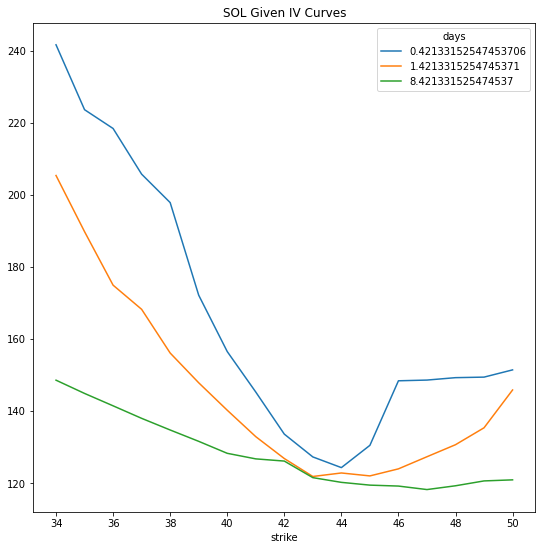

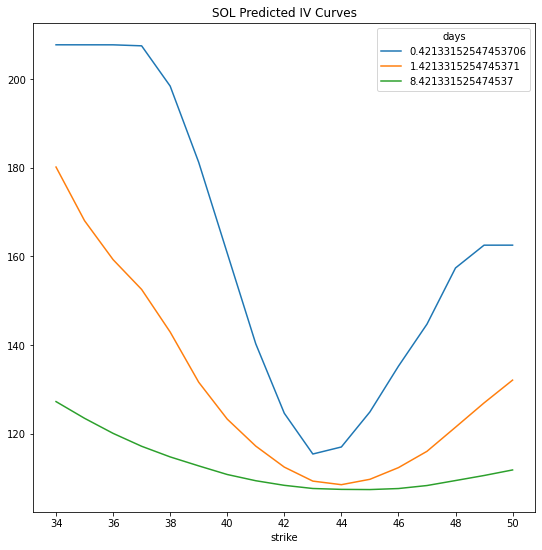

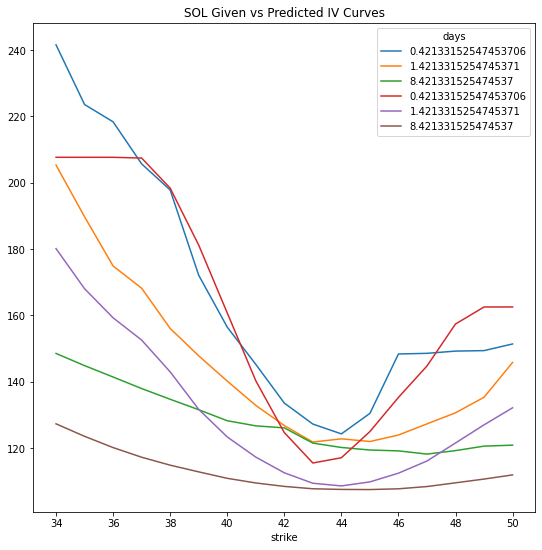

In [12]:
sol_strikes = [34, 50] 
graph_combined_iv_curves('SOL', 43, sol_strikes)

[Int64Index([  5000,  10000,  11000,  12000,  13000,  14000,  15000,  16000,
             16500,  17000,  17500,  18000,  18500,  19000,  19500,  20000,
             20500,  21000,  21500,  22000,  22500,  23000,  23500,  24000,
             24500,  25000,  26000,  27000,  28000,  29000,  30000,  31000,
             32000,  33000,  34000,  35000,  36000,  37000,  38000,  40000,
             42000,  44000,  45000,  46000,  48000,  50000,  55000,  60000,
             65000,  70000,  75000,  80000,  90000, 100000, 120000, 140000,
            150000, 200000, 250000, 300000, 350000, 400000],
           dtype='int64', name='strike'), Float64Index([0.4201857037268519, 1.420185703726852, 8.420185703726853], dtype='float64', name='days')]
Float64Index([0.4201857037268519, 1.420185703726852, 8.420185703726853], dtype='float64', name='days')
days    0.420186  1.420186  8.420186
strike                              
10000        NaN   159.280   175.090
11000        NaN   157.770       NaN
12000    

(days    0.420186  1.420186  8.420186
 strike                              
 10000        NaN   159.280   175.090
 11000        NaN   157.770       NaN
 12000        NaN   157.220   158.950
 13000        NaN   142.910       NaN
 14000        NaN   141.270   150.665
 15000        NaN   140.570   135.340
 16000        NaN   137.900   127.180
 16500        NaN   136.770       NaN
 17000    119.590   136.180   116.435
 17500        NaN   136.130   111.820
 18000    119.590   136.130   106.385
 18500        NaN   136.090   103.035
 19000    119.580   136.040    99.990
 19500        NaN   136.040    97.020
 20000    119.270   126.620    94.500
 20500    119.120   120.850    92.285
 21000    119.120   118.310    90.380
 21500    119.070   109.690    88.670
 22000    112.420   101.040    87.190
 22500    102.665    94.145    86.000
 23000     93.220    88.130    85.050
 23500     87.750    84.380    84.085
 24000     87.745    82.755    83.560
 24500     91.875       NaN    83.400
 25000     9

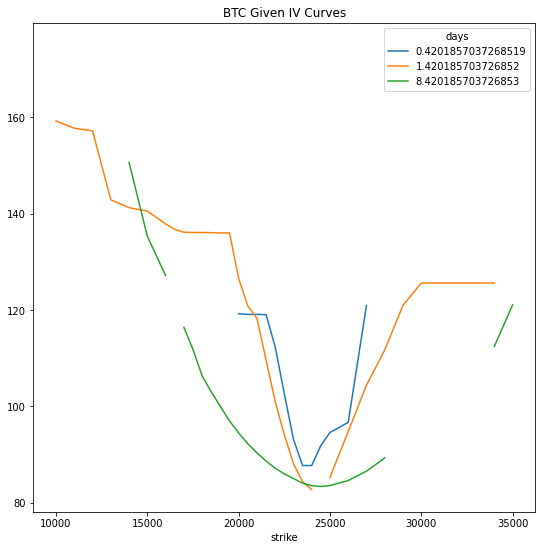

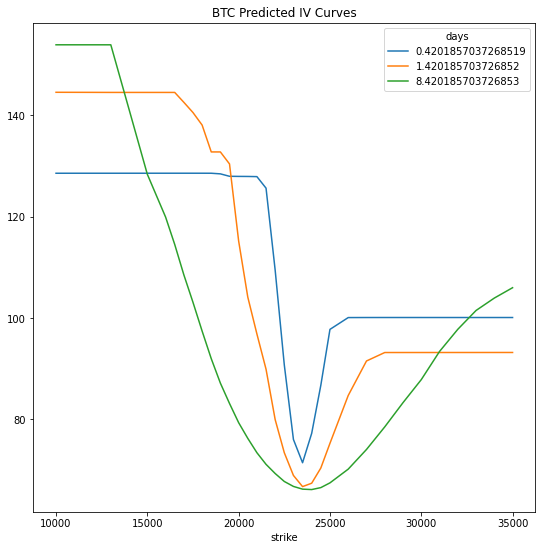

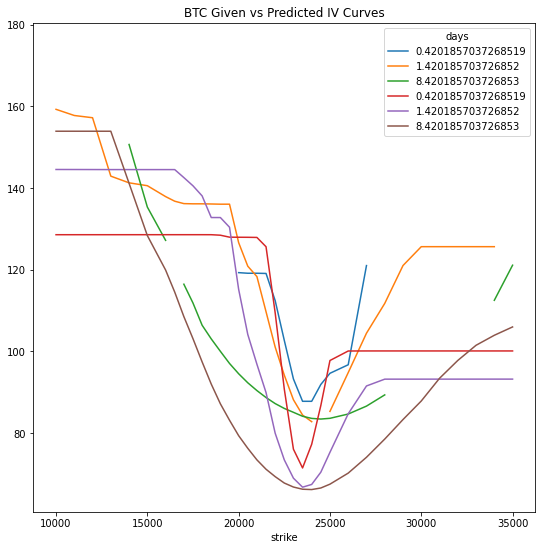

In [13]:
btc_strikes = [10000, 35000] 
graph_combined_iv_curves('BTC', 23295.88, btc_strikes)

days    0.417847    1.417847    8.417847    15.417847   36.417847   \
strike                                                               
5000           NaN         NaN         NaN         NaN         NaN   
10000          NaN      159.28      175.09      162.89      127.94   
11000          NaN      157.77         NaN      158.38         NaN   
12000          NaN      157.22      158.95      140.18      117.82   
13000          NaN      142.91         NaN      135.79         NaN   
...            ...         ...         ...         ...         ...   
200000         NaN         NaN         NaN         NaN         NaN   
250000         NaN         NaN         NaN         NaN         NaN   
300000         NaN         NaN         NaN         NaN         NaN   
350000         NaN         NaN         NaN         NaN         NaN   
400000         NaN         NaN         NaN         NaN         NaN   

days    71.417847   162.417847  253.417847  344.417847  
strike                          

<AxesSubplot:title={'center':'SOL IV Curves'}, xlabel='strike'>

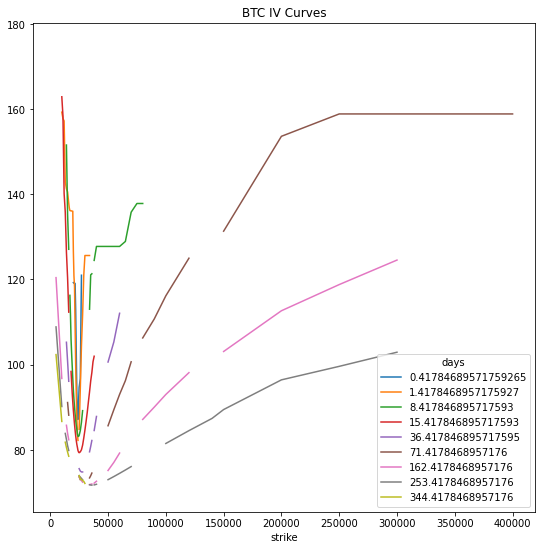

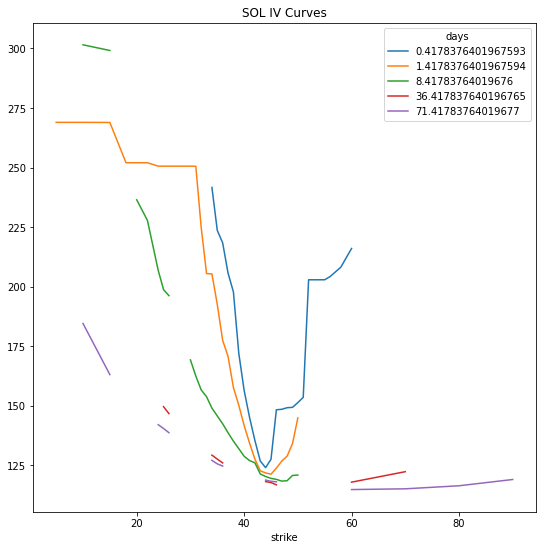

In [14]:
btc_surface = graph_iv_curve('BTC')

print(btc_surface)

btc_surface.plot(kind='line', title='BTC IV Curves', figsize = [9,9])

sol_surface = graph_iv_curve('SOL')

sol_surface.plot(kind='line', title='SOL IV Curves', figsize = [9,9])
